In [ ]:
!git clone https://github.com/lehoangphuongnhi/Thesis.git

Cloning into 'Thesis'...
remote: Enumerating objects: 234, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 234 (delta 22), reused 18 (delta 7), pack-reused 181
Receiving objects: 100% (234/234), 11.15 MiB | 15.99 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [ ]:
cd Thesis

/content/Thesis


In [ ]:
!make start-gpu
!pip install wget

make: *** No rule to make target 'start-gpu'.  Stop.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=0b7c2dce830c7025cb29fc5053182e40305e412497fc9cb9fa96342befb9092f
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:

from Code.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload

%autoreload 2

# Download Sarcos dataset

In [ ]:
import numpy as np
from scipy.io import loadmat

data = loadmat('/content/Thesis/sarcos_inv.mat')['sarcos_inv'].astype(np.float32)
val_data, train_data = data[:4500], data[4500:].astype(np.float32)
test_data = loadmat('/content/Thesis/sarcos_inv_test.mat')['sarcos_inv_test'].astype(np.float32)

# train_data = pd.DataFrame(train_data)
# val_data = pd.DataFrame(val_data)
# test_data = pd.DataFrame(test_data)


# X_train, Y_train = train_data[np.array(range(21))], train_data[np.array(range(21, 28))]

X_train, y_train = train_data[:, :21], train_data[:, 21:]
X_valid, y_valid = val_data[:, :21], val_data[:, 21:]
X_test, y_test = test_data[:, :21], test_data[:, 21:]

#TabNet-M

In [ ]:
clf = TabNetRegressor(n_d=128, n_a=128, n_steps=5,
    gamma=1.5, n_ind=2, n_shared=2,
    cat_idxs=[],
    cat_dims=[],
    cat_emb_dim=[],
    lambda_sparse=1e-4, momentum=0.8,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.9,
                     "step_size": 400},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
    )

/content/Thesis/Code/abstract_model.py:74: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
max_epochs = 70 if not os.getenv("CI", False) else 2

In [ ]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'test'],
    eval_metric=['mse'],
    max_epochs=max_epochs,
    patience= 500,
    batch_size=4096, vbs=128,
    num_workers=0,
    drop_last=False
) 

epoch 0  | loss: 121.71628| train_mse: 346.4646301269531| test_mse: 565.5200805664062|  0:00:02s
epoch 1  | loss: 45.63015| train_mse: 257.32391357421875| test_mse: 294.8886413574219|  0:00:04s
epoch 2  | loss: 34.61805| train_mse: 158.77931213378906| test_mse: 191.00465393066406|  0:00:07s
epoch 3  | loss: 29.28643| train_mse: 135.52378845214844| test_mse: 107.87168884277344|  0:00:09s
epoch 4  | loss: 24.1054 | train_mse: 89.42732238769531| test_mse: 75.67417907714844|  0:00:11s
epoch 5  | loss: 19.80243| train_mse: 77.98905181884766| test_mse: 74.47576904296875|  0:00:13s
epoch 6  | loss: 18.22598| train_mse: 45.96253967285156| test_mse: 56.869319915771484|  0:00:16s
epoch 7  | loss: 16.27129| train_mse: 47.90652847290039| test_mse: 59.857120513916016|  0:00:18s
epoch 8  | loss: 14.9827 | train_mse: 41.19990158081055| test_mse: 48.49473190307617|  0:00:21s
epoch 9  | loss: 14.03495| train_mse: 42.08351135253906| test_mse: 55.47806930541992|  0:00:23s
epoch 10 | loss: 12.37026| train

/content/Thesis/Code/callbacks.py:155: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


#Predict

In [ ]:
preds = clf.predict(X_valid)

test_mse = mean_squared_error(y_pred=preds, y_true=y_valid)

print(f"BEST VALID SCORE FOR Sarcos : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR Sarcos : {test_mse}")

BEST VALID SCORE FOR Sarcos : 11.212898254394531
FINAL TEST SCORE FOR Sarcos : 11.212898254394531


#Global explainability : feat importance summing to 1


In [ ]:
clf.feature_importances_


array([8.13327352e-02, 6.91418492e-02, 3.93090279e-02, 8.03246705e-03,
       7.81189485e-02, 6.13506098e-03, 7.60987719e-03, 1.45107255e-02,
       3.15075269e-02, 2.17905552e-05, 1.89995829e-03, 2.67447919e-02,
       2.96094641e-03, 3.47746741e-02, 2.73076290e-01, 1.08202251e-01,
       5.88247536e-02, 9.74337979e-02, 2.23378814e-02, 2.86905022e-03,
       3.51555972e-02])

#Local explainability and masks


In [ ]:
explain_matrix, masks = clf.explain(X_valid)


In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

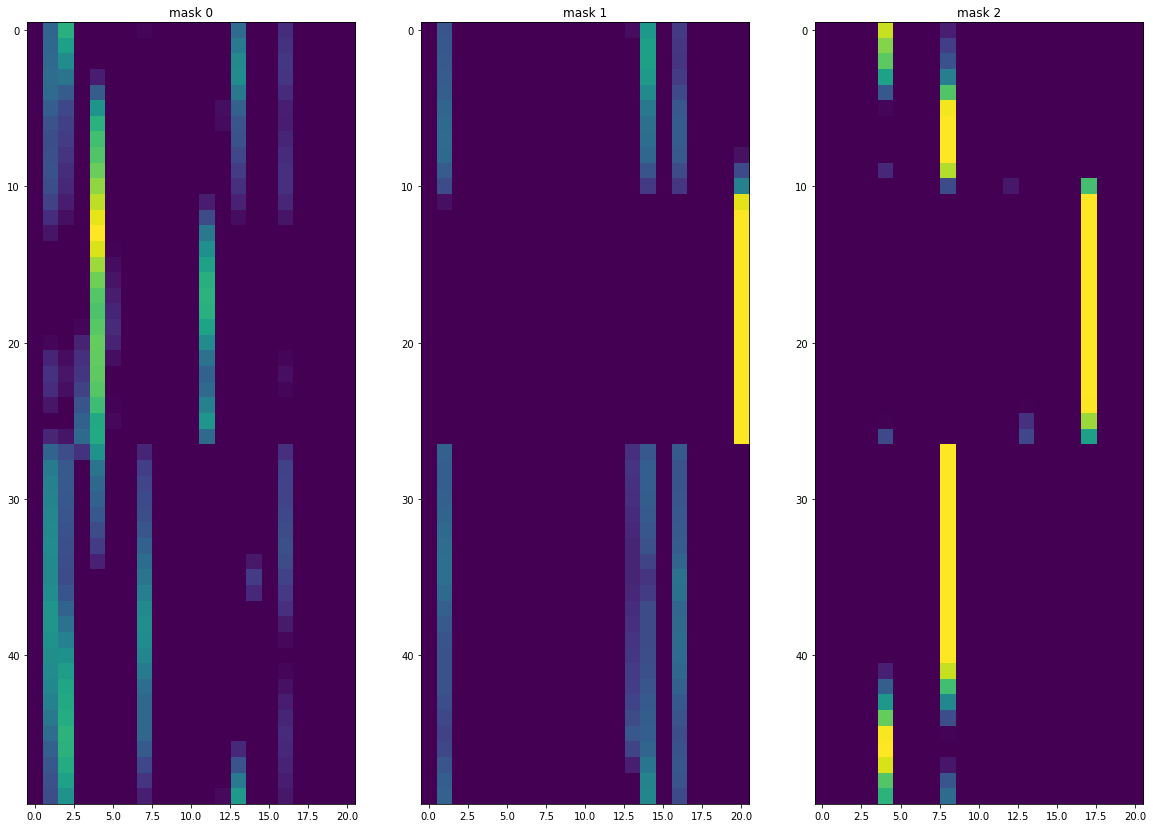

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

#XGboost

In [ ]:
!pip uninstall xgboost

Found existing installation: xgboost 0.90
Uninstalling xgboost-0.90:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/xgboost-0.90.dist-info/*
    /usr/local/lib/python3.7/dist-packages/xgboost/*
    /usr/local/xgboost/libxgboost.so
Proceed (y/n)? y
  Successfully uninstalled xgboost-0.90


In [ ]:
!pip install xgboost==1.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 192.9 MB 26 kB/s 


In [ ]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators = 200, max_depth = 5, objective = 'reg:squarederror')

In [ ]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_metric = 'rmse'
)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-rmse:13.95809	validation_1-rmse:14.40124
[1]	validation_0-rmse:10.29839	validation_1-rmse:10.90345
[2]	validation_0-rmse:7.78019	validation_1-rmse:8.55102
[3]	validation_0-rmse:6.06862	validation_1-rmse:7.02175
[4]	validation_0-rmse:4.90289	validation_1-rmse:6.03014
[5]	validation_0-rmse:4.14869	validation_1-rmse:5.39864
[6]	validation_0-rmse:3.63002	validation_1-rmse:5.02948
[7]	validation_0-rmse:3.28562	validation_1-rmse:4.76563
[8]	validation_0-rmse:3.04761	validation_1-rmse:4.63664
[9]	validation_0-rmse:2.86711	validation_1-rmse:4.45730
[10]	validation_0-rmse:2.74055	validation_1-rmse:4.38113
[11]	validation_0-rmse:2.65525	validation_1-rmse:4.31730
[12]	validation_0-rmse:2.56318	validation_1-rmse:4.27585
[13]	validation_0-rmse:2.49760	validation_1-rmse:4.20716
[14]	validation_0-rmse:2.44060	validation_1-rmse:4.16856
[15]	validation_0-rmse:2.39129	validation_1-rmse:4.14287
[16]	validation_0-rmse:2.34154	validation_1-rmse:4.10567
[17]	validation_0-rmse:2.29780	valida

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [ ]:
Y_hat_test = model.predict(X_valid)
MSE = np.square(y_valid - Y_hat_test).mean()
print('Test MSE:', MSE)

Test MSE: 11.376756


#Thí nghiệm về thời gian chạy trên số lượng output khác nhau

## TabNet

In [ ]:
train_data = loadmat('sarcos_inv.mat')['sarcos_inv'].astype(np.float32)
val_data, train_data = train_data[:4448], train_data[4484:].astype(np.float32)
test_data = loadmat('sarcos_inv_test.mat')['sarcos_inv_test'].astype(np.float32)

In [ ]:
X_train = {}
Y_train = {}
X_val = {}
Y_val = {}
X_test = {}
Y_test = {}

In [ ]:
X_train[1], Y_train[1] = train_data[:, :21], train_data[:, 21]
X_val[1], Y_val[1] = val_data[:, :21], val_data[:, 21]
X_test[1], Y_test[1] = test_data[:, :21], test_data[:, 21]

In [ ]:
X_train[3], Y_train[3] = train_data[:, :21], train_data[:, 21:24]
X_val[3], Y_val[3] = val_data[:, :21], val_data[:, 21:24]
X_test[3], Y_test[3] = test_data[:, :21], test_data[:, 21:24]

In [ ]:
X_train[5], Y_train[5] = train_data[:, :21], train_data[:, 21:26]
X_val[5], Y_val[5] = val_data[:, :21], val_data[:, 21:26]
X_test[5], Y_test[5] = test_data[:, :21], test_data[:, 21:26]

In [ ]:
X_train[7], Y_train[7] = train_data[:, :21], train_data[:, 21:]
X_val[7], Y_val[7] = val_data[:, :21], val_data[:, 21:]
X_test[7], Y_test[7] = test_data[:, :21], test_data[:, 21:]

In [ ]:
clf = TabNetRegressor(n_d=128, n_a=128, n_steps=5,
    gamma=1.5, n_ind=2, n_shared=2,
    cat_idxs=[],
    cat_dims=[],
    cat_emb_dim=[],
    lambda_sparse=1e-4, momentum=0.8,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.9,
                     "step_size": 400},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
    )

/content/Thesis/Code/abstract_model.py:74: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
clf.fit(
    X_train=X_train[1], y_train=Y_train[1].reshape(-1,1),
    eval_set=[(X_train[1], Y_train[1].reshape(-1,1)), (X_val[1], Y_val[1].reshape(-1,1))],
    eval_name=['train', 'test'],
    eval_metric=['mse'],
    max_epochs=70,
    patience= 70,
    batch_size=4096, vbs=128,
    num_workers=0,
    drop_last=False
) 

In [ ]:
clf.fit(
    X_train=X_train[3], y_train=Y_train[3],
    eval_set=[(X_train[3], Y_train[3]), (X_val[3], Y_val[3])],
    eval_name=['train', 'test'],
    eval_metric=['mse'],
    max_epochs=70,
    patience= 70,
    batch_size=4096, vbs=128,
    num_workers=0,
    drop_last=False
) 

In [ ]:
clf.fit(
    X_train=X_train[5], y_train=Y_train[5],
    eval_set=[(X_train[5], Y_train[5]), (X_val[5], Y_val[5])],
    eval_name=['train', 'test'],
    eval_metric=['mse'],
    max_epochs=70,
    patience= 70,
    batch_size=4096, vbs=128,
    num_workers=0,
    drop_last=False
) 

In [ ]:
clf.fit(
    X_train=X_train[7], y_train=Y_train[7],
    eval_set=[(X_train[7], Y_train[7]), (X_val[7], Y_val[7])],
    eval_name=['train', 'test'],
    eval_metric=['mse'],
    max_epochs=70,
    patience= 70,
    batch_size=4096, vbs=128,
    num_workers=0,
    drop_last=False
) 

##XGBoost

In [ ]:
!pip uninstall xgboost

Found existing installation: xgboost 0.90
Uninstalling xgboost-0.90:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/xgboost-0.90.dist-info/*
    /usr/local/lib/python3.7/dist-packages/xgboost/*
    /usr/local/xgboost/libxgboost.so
Proceed (y/n)? y
  Successfully uninstalled xgboost-0.90


In [ ]:
!pip install xgboost==1.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 192.9 MB 56 kB/s 


In [ ]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators = 200, max_depth = 5, objective = 'reg:squarederror')

In [ ]:
model.fit(
    X_train[1], Y_train[1],
    eval_set=[(X_train[1], Y_train[1]), (X_val[1], Y_val[1])],
    eval_metric = 'rmse'
)

In [ ]:
model.fit(
    X_train[3], Y_train[3],
    eval_set=[(X_train[3], Y_train[3]), (X_val[3], Y_val[3])],
    eval_metric = 'rmse'
)

In [ ]:
model.fit(
    X_train[5], Y_train[5],
    eval_set=[(X_train[5], Y_train[5]), (X_val[5], Y_val[5])],
    eval_metric = 'rmse'
)

In [ ]:
model.fit(
    X_train[7], Y_train[7],
    eval_set=[(X_train[7], Y_train[7]), (X_val[7], Y_val[7])],
    eval_metric = 'rmse'
)